# Complete experiment to try to estimate the probability of an offer to "succeed" with one customer. The "informative" offers are considered successful if the customer views them. Other kinds of offers are successful only if the customer views them, and then completes them.

Table of contents <a id='top'>

1. [Get the data and show it](#data)
2. [Create the Model](#model)
3. [Evaluate the Model](#eval)
4. [Analysis and Conclusions](#conclusions)
5. [Test Results](#test)

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.visualization.visualize as vis

## 1. Get the data and show it <a id='data'/>
[Top](#top)

In [2]:
# Get the data
STATIC_DATASET_PATH = os.path.join(DATA_PROCESSED, 'static_cluster_lagged.pkl')

X_train_val, X_test, y_train_val, y_test, encoder = sd.get_success_data(
    basic_dataset_path=STATIC_DATASET_PATH,
    drop_time=False)

# Time-split validation datasets
X_test = pp.drop_time_dependent(X_test)
X_train, X_val, y_train, y_val = pp.time_split(X_train_val, 
                                               y_train_val,
                                               time_limit=370)

In [3]:
print(X_train.shape)
print(y_train.shape)
X_train.head()

(38030, 117)
(38030,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
0,33.0,M,72000.0,0,17277,0.0,3.0,informational,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,33.0,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,40.0,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,40.0,O,57000.0,0,17540,7.0,7.0,discount,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print(X_val.shape)
print(y_val.shape)
X_val.head()

(12778, 117)
(12778,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
2,33.0,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
10,40.0,O,57000.0,0,17540,20.0,10.0,discount,5.0,1.0,...,0.99999,0.0,0.0,0.00000,0.99999,0.000000,0.499998,0.333332,0.499998,0.333332
15,59.0,F,90000.0,0,16864,10.0,5.0,bogo,10.0,1.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.999995,0.999995,0.666664,0.666664,0.666664
19,24.0,F,60000.0,0,17116,0.0,3.0,informational,0.0,0.0,...,0.99999,0.0,0.0,0.99999,0.99999,0.000000,0.999995,0.999995,0.999995,0.999995
24,26.0,F,73000.0,0,17338,10.0,10.0,discount,2.0,1.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.999990,0.499998,0.333332,0.499998,0.333332


In [9]:
print(X_test.shape)
print(y_test.shape)
X_test.head()

(25469, 117)
(25469,)


,age,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_web,...,difficulty_7.0_success_ratio,reward_10.0_success_ratio,reward_0.0_success_ratio,reward_5.0_success_ratio,reward_3.0_success_ratio,reward_2.0_success_ratio,channel_web_success_ratio,channel_email_success_ratio,channel_social_success_ratio,channel_mobile_success_ratio
3,33.0,M,72000.0,0,17277,10.0,10.0,discount,2.0,1.0,...,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
4,33.0,M,72000.0,0,17277,10.0,7.0,discount,2.0,1.0,...,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
6,NaN,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,...,0.00000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
11,40.0,O,57000.0,0,17540,5.0,7.0,bogo,5.0,1.0,...,0.99999,0.000000,0.0,0.99999,0.99999,0.000000,0.666664,0.499999,0.499998,0.333332
16,59.0,F,90000.0,0,16864,0.0,3.0,informational,0.0,0.0,...,0.00000,0.499998,0.0,0.00000,0.00000,0.999995,0.999997,0.749998,0.749998,0.749998


## 2. Create the model <a id='model'/>
[Top](#top)

In [6]:
cluster1_feats = ['kmeans_8', 'ward_12', 'dbscan_10']
cluster3d_feats = ['3d_kmeans_3', '3d_ward_3', '3d_ward_9', '3d_ward_19',
                 '3d_gmm_3', '3d_gmm_16', '3d_dbscan_02_20', '3d_dbscan_05_100']

base_model = Pipeline([
    ('encoder', pp.BasicEncoder()),
    ('imputer', md.BasicImputer(fill_mode=cluster1_feats + cluster3d_feats)),
    ('estimator', XGBClassifier(max_depth=7, n_estimators=200, n_thread=0,
                                random_state=2018))
])

In [7]:
# Grid search for better parameters

parameters = {
    'estimator__max_depth': [4, 7],
    'estimator__n_estimators': [10, 200, 500],
    'estimator__subsample': [0.5, 1.0],
    'estimator__colsample_bytree': [0.5, 0.7, 1.0],
    'estimator__colsample_bylevel': [0.5, 0.7, 1.0]
}
cv = GridSearchCV(base_model, parameters, cv=3, n_jobs=-1)

%time cv.fit(X_train, y_train)

print('The best parameters are:')
print(cv.best_params_)
print('-'*100)

model = cv.best_estimator_
model.get_params()

/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/miguel/anaconda3/envs/sbucks/lib/python3

CPU times: user 15.4 s, sys: 771 ms, total: 16.2 s
Wall time: 37min 52s
The best parameters are:
{'estimator__colsample_bylevel': 1.0, 'estimator__colsample_bytree': 0.5, 'estimator__max_depth': 4, 'estimator__n_estimators': 200, 'estimator__subsample': 1.0}
----------------------------------------------------------------------------------------------------


{'memory': None,
 'steps': [('encoder', BasicEncoder()),
  ('imputer',
   BasicImputer(fill_mode=['kmeans_8', 'ward_12', 'dbscan_10', '3d_kmeans_3', '3d_ward_3', '3d_ward_9', '3d_ward_19', '3d_gmm_3', '3d_gmm_16', '3d_dbscan_02_20', '3d_dbscan_05_100'])),
  ('estimator',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
          colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
          max_depth=4, min_child_weight=1, missing=None, n_estimators=200,
          n_jobs=1, n_thread=0, nthread=None, objective='binary:logistic',
          random_state=2018, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=True, subsample=1.0))],
 'encoder': BasicEncoder(),
 'imputer': BasicImputer(fill_mode=['kmeans_8', 'ward_12', 'dbscan_10', '3d_kmeans_3', '3d_ward_3', '3d_ward_9', '3d_ward_19', '3d_gmm_3', '3d_gmm_16', '3d_dbscan_02_20', '3d_dbscan_05_100']),
 'estimator': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylev

In [7]:
model = base_model

## 3. Evaluate the model <a id='eval'/>
[Top](#top)

### Time-split Validation

In [8]:
trained_model, y_train_pred, y_val_pred = evos.time_split_validation(model, 
                                                                     basic_dataset_path=STATIC_DATASET_PATH)

KeyError: 'kmeans_8'

### Customer-split validation

In [9]:
evos.random_1fold_cust_validation(model, basic_dataset_path=STATIC_DATASET_PATH)

Training time: 10.136257886886597 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[14558  4275]
 [ 4760 11956]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     18833
           1       0.74      0.72      0.73     16716

   micro avg       0.75      0.75      0.75     35549
   macro avg       0.75      0.74      0.74     35549
weighted avg       0.75      0.75      0.75     35549

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[5993 2049]
 [2308 4909]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      8042
           1       0.71      0.68      0.69      7217

   micro avg       0.7

## 4. Analysis and Conclusions <a id='conclusions'/>
[Top](#top)

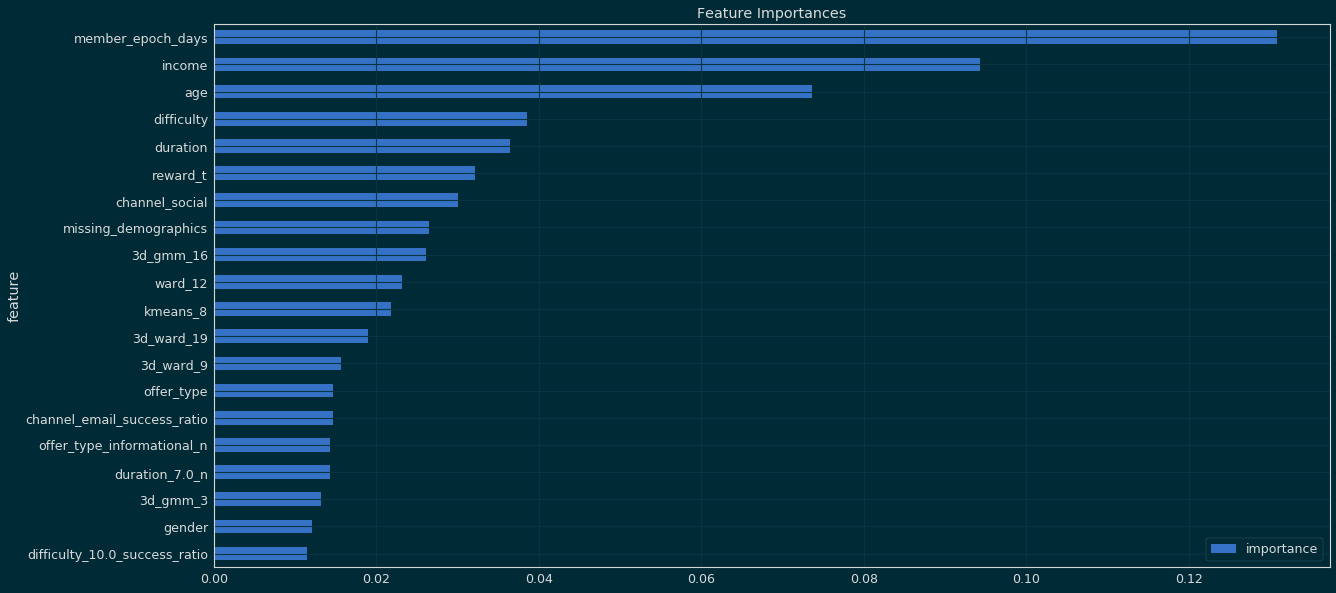

<Figure size 1440x720 with 0 Axes>

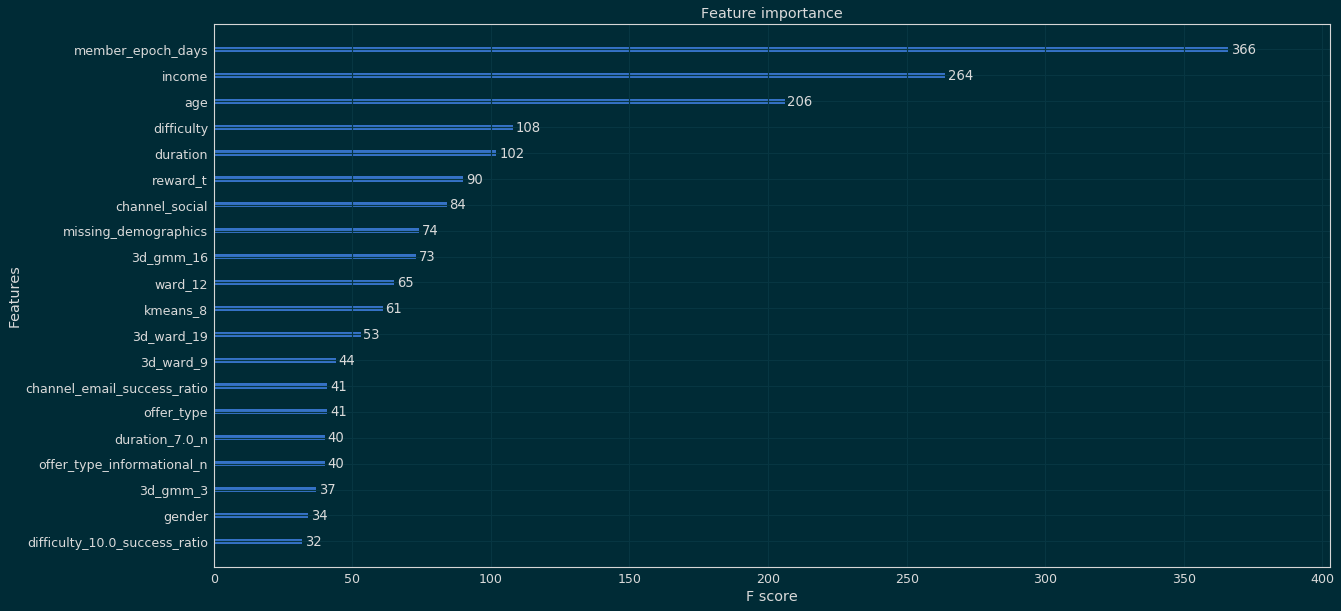

In [18]:
vis.show_feat_importances(model, X_train)

The cluster features are taken into account, but they are not too relevant, and don't seem to change the results too much.

## 5. Test Results (only run this once, after adjusting all the hyperparameters) <a id='test'/>
[Top](#top)

In [11]:
evos.offer_success_test(model, basic_dataset_path=STATIC_DATASET_PATH)

Training time: 14.748873233795166 seconds.
--------------------------------------------TRAIN RESULTS--------------------------------------------
Confusion Matrix:
[[20496  6379]
 [ 6938 16995]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     26875
           1       0.73      0.71      0.72     23933

   micro avg       0.74      0.74      0.74     50808
   macro avg       0.74      0.74      0.74     50808
weighted avg       0.74      0.74      0.74     50808

----------------------------------------------------------------------------------------------------
--------------------------------------------TEST RESULTS--------------------------------------------
Confusion Matrix:
[[10319  3669]
 [ 3228  8253]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.74      0.75     13988
           1       0.69      0.72      0.71     11481

   micro avg      